In [3]:
#!pip install yfinance
import yfinance as yf
from google.cloud import bigquery
import pandas as pd 
import numpy as np
import statsmodels as sm

# Plotting 
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns


# NLP Vaccine Analysis: Do news articles on vaccine correlate with LBG stock price?

## Hypothesis

1) More news is good news.

    That more news about the vaccine positively correlates with LBG stock price.
    BONUS: after controlling for sentiment, this is still significant.

2) The sentiment of the news matters too.

    An increase in positive articles positively correlates, whilst an increase in negative articles negatively correlates.

3) The source of the news is also important.

    That news source matters, and a model with seperate intercepts for each news source is significantly better at predicting stock price than a model without seperate intercepts.

**Null Hypothesis) There is no association between the number of news articles about vaccination and the LBG stock price.**

## Methods

    Hypothesis 1 and 2: Correlation matrix
    Hypothesis 3: Mixed Linear Model (hierarchical multiple linear regression)

Data used:

1) From yahoo finance, get LBG stock price over the past year. The close value is our outcome variable.

2) From bigquery, get the covid articles dataset. Available fields: [DATE, AVG_TONE, AVG_POSITIVE_SCORE, AVG_NEGATIVE_SCORE, AVG_POLARITY, NUMBER_OF_ARTICLES]


## First, collect the outcome variable:


In [4]:
lbg_shares = yf.download("LLOY.L", start="2020-01-01", end="2020-11-01", interval='1d')
lbg_shares.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,63.750000,63.840000,63.240002,63.709999,58.890789,157613349
2020-01-03,63.799999,63.799999,62.450001,63.049999,58.280712,198856652
2020-01-06,63.200001,63.324001,62.071999,63.250000,58.465584,136196286
2020-01-07,63.110001,63.689999,62.889999,63.110001,58.336174,107254282
2020-01-08,62.580002,62.869999,62.009998,62.790001,58.040379,157679455


In [5]:
lbg_shares.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2020-01-02 to 2020-10-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       212 non-null    float64
 1   High       212 non-null    float64
 2   Low        212 non-null    float64
 3   Close      212 non-null    float64
 4   Adj Close  212 non-null    float64
 5   Volume     212 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.6 KB


In [6]:
client = bigquery.Client(location="US", project="goldenfleece")

query = """
    SELECT *
    FROM sentiment.daily_sentiment_2020_covid_theme
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    project='goldenfleece'
)  # API request - starts the query

covid_related_news = query_job.to_dataframe()
covid_related_news.head()

,DATE,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES
0,20200101,-6.017551457,2.149165089,8.166716546,10.315881635,18
1,20200102,-5.378190877,1.556339353,6.93453023,8.490869583,50
2,20200103,-5.884740139,1.721482468,7.606222607,9.327705075,40
3,20200104,-5.213566203,2.195057625,7.408623828,9.603681452,42
4,20200105,-5.526246926,1.687839156,7.214086083,8.901925239,18


In [7]:
# Date column needs reformating on both dataframes to allow comparison. 
covid_related_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DATE                330 non-null    object
 1   AVG_TONE            330 non-null    object
 2   AVG_POSITIVE_SCORE  330 non-null    object
 3   AVG_NEGATIVE_SCORE  330 non-null    object
 4   AVG_POLARITY        330 non-null    object
 5   NUMBER_OF_ARTICLES  330 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 15.6+ KB


In [8]:
# Looks good - infering well. 
covid_date = pd.to_datetime(covid_related_news['DATE'], infer_datetime_format= True)
covid_date.head()

0   2020-01-01
1   2020-01-02
2   2020-01-03
3   2020-01-04
4   2020-01-05
Name: DATE, dtype: datetime64[ns]

In [9]:
# Reassign as the index and drop original column. 
covid_related_news.DATE = covid_date
covid_related_news.set_index('DATE', inplace=True, drop=True)
covid_related_news.head()

,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES
DATE,,,,,
2020-01-01,-6.017551457,2.149165089,8.166716546,10.315881635,18
2020-01-02,-5.378190877,1.556339353,6.93453023,8.490869583,50
2020-01-03,-5.884740139,1.721482468,7.606222607,9.327705075,40
2020-01-04,-5.213566203,2.195057625,7.408623828,9.603681452,42
2020-01-05,-5.526246926,1.687839156,7.214086083,8.901925239,18


In [10]:
df = covid_related_news.join(lbg_shares) # on index and via left join by default. 
df.head(30)

,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES,Open,High,Low,Close,Adj Close,Volume
DATE,,,,,,,,,,,
2020-01-01,-6.017551457,2.149165089,8.166716546,10.315881635,18,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,-5.378190877,1.556339353,6.93453023,8.490869583,50,63.750000,63.840000,63.240002,63.709999,58.890789,157613349.0
2020-01-03,-5.884740139,1.721482468,7.606222607,9.327705075,40,63.799999,63.799999,62.450001,63.049999,58.280712,198856652.0
2020-01-04,-5.213566203,2.195057625,7.408623828,9.603681452,42,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,-5.526246926,1.687839156,7.214086083,8.901925239,18,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,-5.413489032,1.969599047,7.383088078,9.352687125,73,63.200001,63.324001,62.071999,63.250000,58.465584,136196286.0
2020-01-07,-5.342589876,1.808465407,7.151055283,8.95952069,41,63.110001,63.689999,62.889999,63.110001,58.336174,107254282.0
2020-01-08,-5.51025746,1.942083843,7.452341303,9.394425145,33,62.580002,62.869999,62.009998,62.790001,58.040379,157679455.0
2020-01-09,-5.387547309,1.329941781,6.71748909,8.047430871,829,63.450001,63.500000,61.745998,61.849998,57.171482,173659260.0


In [11]:
analysis_df = df.dropna(axis=0)

analysis_df.head()

,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES,Open,High,Low,Close,Adj Close,Volume
DATE,,,,,,,,,,,
2020-01-02,-5.378190877,1.556339353,6.93453023,8.490869583,50,63.750000,63.840000,63.240002,63.709999,58.890789,157613349.0
2020-01-03,-5.884740139,1.721482468,7.606222607,9.327705075,40,63.799999,63.799999,62.450001,63.049999,58.280712,198856652.0
2020-01-06,-5.413489032,1.969599047,7.383088078,9.352687125,73,63.200001,63.324001,62.071999,63.250000,58.465584,136196286.0
2020-01-07,-5.342589876,1.808465407,7.151055283,8.95952069,41,63.110001,63.689999,62.889999,63.110001,58.336174,107254282.0
2020-01-08,-5.51025746,1.942083843,7.452341303,9.394425145,33,62.580002,62.869999,62.009998,62.790001,58.040379,157679455.0


In [12]:
# Needs conversion to numeric..
analysis_df = analysis_df.apply(pd.to_numeric, axis=1, errors='coerce')
analysis_df.info() 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2020-01-02 to 2020-10-30
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AVG_TONE            212 non-null    float64
 1   AVG_POSITIVE_SCORE  212 non-null    float64
 2   AVG_NEGATIVE_SCORE  212 non-null    float64
 3   AVG_POLARITY        212 non-null    float64
 4   NUMBER_OF_ARTICLES  212 non-null    float64
 5   Open                212 non-null    float64
 6   High                212 non-null    float64
 7   Low                 212 non-null    float64
 8   Close               212 non-null    float64
 9   Adj Close           212 non-null    float64
 10  Volume              212 non-null    float64
dtypes: float64(11)
memory usage: 19.9 KB


In [13]:
analysis_df.head()

,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES,Open,High,Low,Close,Adj Close,Volume
DATE,,,,,,,,,,,
2020-01-02,-5.378191,1.556339,6.934530,8.490870,50.0,63.750000,63.840000,63.240002,63.709999,58.890789,157613349.0
2020-01-03,-5.884740,1.721482,7.606223,9.327705,40.0,63.799999,63.799999,62.450001,63.049999,58.280712,198856652.0
2020-01-06,-5.413489,1.969599,7.383088,9.352687,73.0,63.200001,63.324001,62.071999,63.250000,58.465584,136196286.0
2020-01-07,-5.342590,1.808465,7.151055,8.959521,41.0,63.110001,63.689999,62.889999,63.110001,58.336174,107254282.0
2020-01-08,-5.510257,1.942084,7.452341,9.394425,33.0,62.580002,62.869999,62.009998,62.790001,58.040379,157679455.0


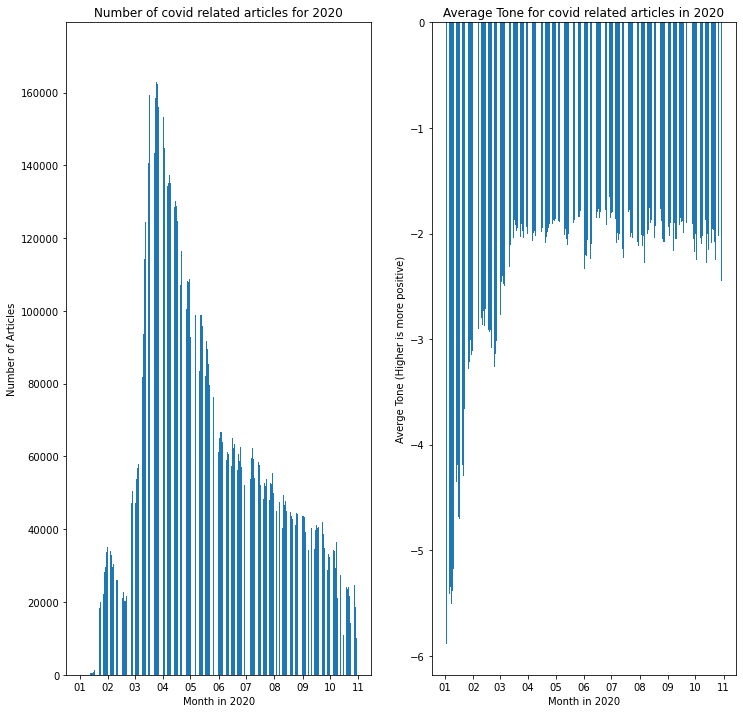

In [14]:
# Create figure and plot space
fig, ax = plt.subplots(1,2,figsize=(12, 12))

# Define the date format
date_form = DateFormatter("%m")

# Number of articles plot
ax[0].bar(analysis_df.index.values,
       analysis_df['NUMBER_OF_ARTICLES'])

# Set title and labels for axes
ax[0].set(xlabel="Month in 2020",
       ylabel="Number of Articles",
       title="Number of covid related articles for 2020")


ax[0].xaxis.set_major_formatter(date_form)

# Overall Tone Plot
ax[1].bar(analysis_df.index.values,
       analysis_df['AVG_TONE'])

# Set title and labels for axes
ax[1].set(xlabel="Month in 2020",
       ylabel="Averge Tone (Higher is more positive)",
       title="Average Tone for covid related articles in 2020")
ax[1].xaxis.set_major_formatter(date_form)


plt.show()

# First, take the first order difference to minimise auto-correlations

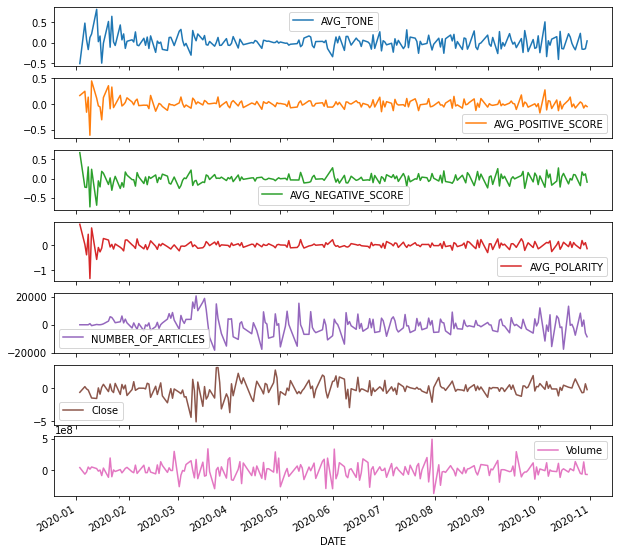

In [21]:
cols_of_interest = ['AVG_TONE', 'AVG_POSITIVE_SCORE', 'AVG_NEGATIVE_SCORE', 'AVG_POLARITY', 'NUMBER_OF_ARTICLES', 'Close', 'Volume']

dif = analysis_df.loc[:, cols_of_interest].diff()

dif.plot(subplots=True, figsize=(10,10))
plt.show()

In [19]:
dif.corr() # correlation between first-order differences.

,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES,Close,Volume
AVG_TONE,1.000000,0.577097,-0.825700,-0.354026,0.094076,0.032705,-0.151347
AVG_POSITIVE_SCORE,0.577097,1.000000,-0.015815,0.559477,0.030330,0.005636,-0.132095
AVG_NEGATIVE_SCORE,-0.825700,-0.015815,1.000000,0.819894,-0.094229,-0.036148,0.094055
AVG_POLARITY,-0.354026,0.559477,0.819894,1.000000,-0.060745,-0.026738,0.002331
NUMBER_OF_ARTICLES,0.094076,0.030330,-0.094229,-0.060745,1.000000,-0.076605,0.142745
Close,0.032705,0.005636,-0.036148,-0.026738,-0.076605,1.000000,-0.092367
Volume,-0.151347,-0.132095,0.094055,0.002331,0.142745,-0.092367,1.000000



## Hypothesis 1) More news is good news.

    That more news about the vaccine positively correlates with LBG stock price.

### Interpretation of correlation results: Weakly contrasting (stock gets worse), but see caveat.

    A small negative correlation is observsed between the number of covid articles and the close price of LBG stock (more news is correlated with a lower stock price). However, this is very weak (-0.077) and should likely not be interpreted. 

## Hypothesis 2) The sentiment of the news matters too

    Original hypothesis 2 was that an increase in positive articles positively correlates, whilst an increase in negative articles negatively correlates.

### Interpretation of correlation results: Very weakly supporting, too little to interpret. 

    First observation is that all correlations are <.10, with the strongest being the number of articles - it would appear that, day by day, the sentiment is not strongly correlated to the stock price. 

    Second observation is that the direction of the correlation is as expected, but strengths are too small to reliably interpret (i.e., positive sentiment is +.005, negative sentiment is -.036). 
